<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) | [Contents](Index.ipynb) | [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb) >

#  In Depth: Principal Component Analysis Iris Dataset

The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis.[1] It is sometimes called Anderson's Iris data set because Edgar Anderson collected the data to quantify the morphologic variation of Iris flowers of three related species.[2] Two of the three species were collected in the Gaspé Peninsula "all from the same pasture, and picked on the same day and measured at the same time by the same person with the same apparatus".[3]

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

We begin with the standard imports:

<img align="left" style="padding-right:10px;" src="figures/iris_data_elements.png">

In [2]:
#print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
import pandas as pd 
import math
%matplotlib inline

### Data as table
A basic table is a two-dimensional grid of data, in which the rows represent individual elements of the dataset, and the columns represent quantities related to each of these elements. In general, we will refer to the rows of the matrix as samples, and the number of rows as n_samples and the the columns of the matrix as features, and the number of columns as n_features.

### Features matrix 
This table layout makes clear that the information can be thought of as a two-dimensional numerical array or matrix, called the features matrix with shape [n_samples, n_features]

### Target array
In addition to the feature matrix X, we also generally work with a label or target array, which by convention we will usually call y. The target array is usually one dimensional, with length n_samples, and is generally contained in a NumPy array or Pandas Series.


### Loading the Dataset
In order to load the Iris data directly from the UCI repository, we are going to use the superb pandas library. If you haven’t used pandas yet, I want encourage you to check out the pandas tutorials. If I had to name one Python library that makes working with data a wonderfully simple task, this would definitely be pandas!

In [3]:
df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [5]:
# split data table into data X and class labels y

X = df.ix[:,0:4].values
y = df.ix[:,4].values

Our iris dataset is now stored in form of a 150×4 matrix where the columns are the different features, and every row represents a separate flower sample. Each sample row x can be pictured as a 4-dimensional vector

<img align="center" style="padding-right:10px;" src="figures/iris_data_structure.png">

### Exploratory Visualization
To get a feeling for how the 3 different flower classes are distributes along the 4 different features, let us visualize them using histograms

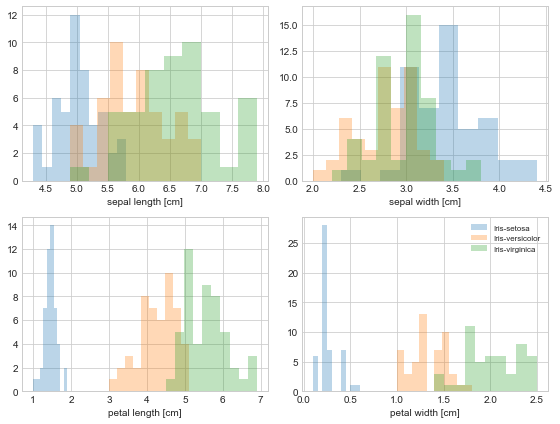

In [6]:
label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

### Standardize the Data
Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

In [7]:
#transformation of the data onto unit scale (mean=0 and variance=1)
X_std = StandardScaler().fit_transform(X)

## 1.  - Eigendecomposition - Computing Eigenvectors and Eigenvalues
The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the “core” of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

### Covariance Matrix
The classic approach to PCA is to perform the eigendecomposition on the covariance matrix Σ, which is a d×d matrix where each element represents the covariance between two features. The covariance between two features is calculated as follows:
<img align="left" style="padding-right:10px;" src="figures/covariance_matrix.png">

In [8]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


The more verbose way above was simply used for demonstration purposes, equivalently, we could have used the numpy cov function:

In [9]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


Next, we perform an eigendecomposition on the covariance matrix:

In [11]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.93035378  0.92740362  0.14834223  0.02074601]


### Correlation Matrix
Especially, in the field of “Finance,” the correlation matrix typically used instead of the covariance matrix. However, the eigendecomposition of the covariance matrix (if the input data was standardized) yields the same results as a eigendecomposition on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix.

Eigendecomposition of the standardized data based on the correlation matrix:

In [14]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.91081808  0.92122093  0.14735328  0.02060771]


Eigendecomposition of the raw data based on the correlation matrix:

In [15]:
cor_mat2 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.91081808  0.92122093  0.14735328  0.02060771]


We can clearly see that all three approaches yield the same eigenvectors and eigenvalue pairs:

Eigendecomposition of the covariance matrix after standardizing the data.
Eigendecomposition of the correlation matrix.
Eigendecomposition of the correlation matrix after standardizing the data.

#### Singular Vector Decomposition
While the eigendecomposition of the covariance or correlation matrix may be more intuitiuve, most PCA implementations perform a Singular Vector Decomposition (SVD) to improve the computational efficiency. So, let us perform an SVD to confirm that the result are indeed the same:

In [16]:
u,s,v = np.linalg.svd(X_std.T)
u

array([[-0.52237162, -0.37231836,  0.72101681,  0.26199559],
       [ 0.26335492, -0.92555649, -0.24203288, -0.12413481],
       [-0.58125401, -0.02109478, -0.14089226, -0.80115427],
       [-0.56561105, -0.06541577, -0.6338014 ,  0.52354627]])

## 2 - Selecting Principal Components

### Sorting Eigenpairs
The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [17]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In order to decide which eigenvector(s) can dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [18]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.91081808375
0.921220930707
0.147353278305
0.0206077072356


### Explained Variance
After sorting the eigenpairs, the next question is “how many principal components are we going to choose for our new feature subspace?” A useful measure is the so-called “explained variance,” which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [19]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

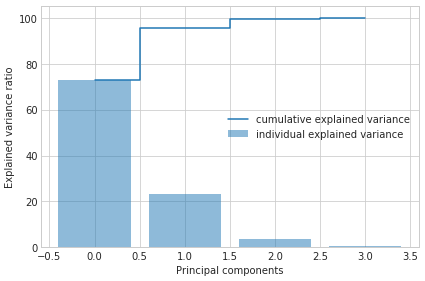

In [20]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components contain 95.8% of the information.

### Projection Matrix
It’s about time to get to the really interesting part: The construction of the projection matrix that will be used to transform the Iris data onto the new feature subspace. Although, the name “projection matrix” has a nice ring to it, it is basically just a matrix of our concatenated top k eigenvectors.

Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the “top 2” eigenvectors with the highest eigenvalues to construct our d×k-dimensional eigenvector matrix W.

In [21]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1),
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


## 3 - Projection Onto the New Feature Space

In this last step we will use the 4×2-dimensional projection matrix **W** to transform our samples onto the new subspace via the equation
**Y=X×W** , where **Y** is a 150×2 matrix of our transformed samples.

In [22]:
Y = X_std.dot(matrix_w)

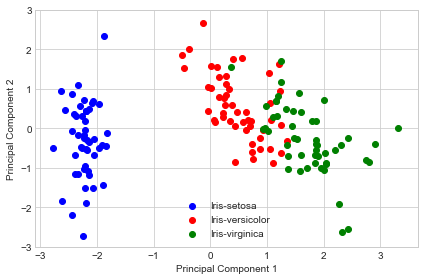

In [23]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

Now, what we got after applying the linear PCA transformation is a lower dimensional subspace (from 3D to 2D in this case), where the samples are “most spread” along the new feature axes.

### Shortcut - PCA in scikit-learn
For educational purposes, we went a long way to apply the PCA to the Iris dataset. But luckily, there is already implementation in scikit-learn.

In [28]:
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

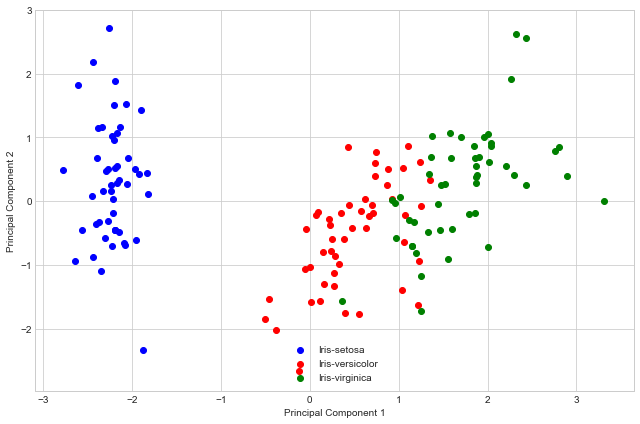

In [29]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

**What are the limitations of PCA?**
* PCA is not scale invariant. check: we need to scale our data first.
* The directions with largest variance are assumed to be of the most interest
* Only considers orthogonal transformations (rotations) of the original variables
* PCA is only based on the mean vector and covariance matrix. Some distributions (multivariate normal) are characterized by this, but some are not.
* If the variables are correlated, PCA can achieve dimension reduction. If not, PCA just orders them according to their variances.

## Principal Component Analysis Summary

In this section we have discussed the use of principal component analysis for dimensionality reduction, for visualization of high-dimensional data, for noise filtering, and for feature selection within high-dimensional data.
Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines.
Given any high-dimensional dataset, I tend to start with PCA in order to visualize the relationship between points (as we did with the digits), to understand the main variance in the data (as we did with the eigenfaces), and to understand the intrinsic dimensionality (by plotting the explained variance ratio).
Certainly PCA is not useful for every high-dimensional dataset, but it offers a straightforward and efficient path to gaining insight into high-dimensional data.

PCA's main weakness is that it tends to be highly affected by outliers in the data.
For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components.
Scikit-Learn contains a couple interesting variants on PCA, including ``RandomizedPCA`` and ``SparsePCA``, both also in the ``sklearn.decomposition`` submodule.